In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns

from importlib import reload

import sys, os
sys.path.append('/home/apizzuto/Nova/scripts/')
import plotting

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

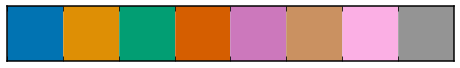

In [3]:
palette = sns.color_palette("colorblind", 8)
sns.palplot(palette)

In [4]:
elias_novae = pd.read_csv('/home/apizzuto/Nova/source_list/nova_stats_from_elias_reformatted.csv')

In [86]:
# elias_novae = elias_novae[['Nova', 'Discovery date/eruption start (t0)', 'Date of optical peak',
#        'Tmax – t0', 'RA', 'Dec',
#        'Average Flux (10^-7 ph/s/cm^2)', 'Average Flux uncertainty',
#        'Spectral index', 'Spectral Index uncertainty',
#        'gamma_start', 'gamma_end']]

In [7]:
elias_novae = elias_novae[['Nova', 'Date of optical peak',
       'RA', 'Dec',
       'Average Flux (10^-7 ph/s/cm^2)',
       'Spectral index',
       'gamma_start', 'gamma_end']]

In [8]:
elias_novae

,Nova,Date of optical peak,RA,Dec,Average Flux (10^-7 ph/s/cm^2),Spectral index,gamma_start,gamma_end
0,YZ Ret,2020-07-10,58:29.5,-54:46:41.20,2.8,1.59,2017-07-10,2017-07-24
1,V1707 Sco,2019-09-16,37:09.6,-35:10:21.10,2.3,2.00,2019-09-15,2019-09-18
2,V392 Per,2018-04-29.5,43:21.4,21:52.8,2.2,2.00,2018-04-30,2018-05-08
3,V906 Car,2018-03-16.88,36:13.7,-59:35:54.90,12.2,2.04,2018-04-08,2018-05-01
4,V357 Mus,2018-01-11,26:15.2,-65:31:23.30,1.3,2.20,2018-01-11,2018-02-07
5,V549 Vel,2017-10-03,50:29.6,-47:45:28.56,0.4,1.80,2017-10-11,2017-11-13
6,V5856 Sgr,2016-11-09,20:52.1,-28:22:13.52,4.6,2.11,2016-11-08,2016-11-23
7,V5855 Sgr,2016-10-24.8,10:28.3,-27:29:59,3.0,2.26,2016-10-25,2016-11-20
8,V407 Lup,2019-09-25.4,29:01.8,-44:49:40.89,1.6,2.20,2016-09-26,2016-09-29
9,V5668 Sgr,2015-03-21,18::36:56.87,-28:55:39.30,1.1,2.42,2015-03-24,2015-05-16


In [89]:
def clean_time_str(t):
    if not '.' in t:
        tmp = Time(t, scale='utc', format='iso').mjd
    else:
        date, frac = t.split('.')
        frac = '.' + frac
        frac = float(frac)
        mjd_date = Time(date, format='iso', scale='utc').mjd
        tmp = Time(mjd_date + frac, scale='utc', format='mjd').mjd
    return tmp

In [90]:
elias_novae['Date of optical peak'] = elias_novae['Date of optical peak'].apply(clean_time_str)
elias_novae['gamma_start'] = elias_novae['gamma_start'].apply(clean_time_str)
elias_novae['gamma_end'] = elias_novae['gamma_end'].apply(clean_time_str)

In [91]:
elias_novae.head()

,Nova,Date of optical peak,RA,Dec,Average Flux (10^-7 ph/s/cm^2),Spectral index,gamma_start,gamma_end
0,YZ Ret,59040.00,58:29.5,-54:46:41.20,2.8,1.59,57944.0,57958.0
1,V1707 Sco,58742.00,37:09.6,-35:10:21.10,2.3,2.00,58741.0,58744.0
2,V392 Per,58237.50,43:21.4,21:52.8,2.2,2.00,58238.0,58246.0
3,V906 Car,58193.88,36:13.7,-59:35:54.90,12.2,2.04,58216.0,58239.0
4,V357 Mus,58129.00,26:15.2,-65:31:23.30,1.3,2.20,58129.0,58156.0


In [92]:
old_master = pd.read_pickle('/home/apizzuto/Nova/master_nova_dataframe.pkl')

In [94]:
comp_dict = {'Name': [],
                'old_gam_start': [],
                'old_gam_stop': [],
                'new_gam_start': [],
                'new_gam_stop': []}

for ii, nov in elias_novae.iterrows():
    if  len(old_master['Name'][old_master['Name'] == nov['Nova']]) == 1:
        comp_dict['Name'].append(nov['Nova'])
        comp_dict['old_gam_start'].append(old_master['gamma_start'][old_master['Name'] == nov['Nova']].values[0].mjd)
        comp_dict['old_gam_stop'].append(old_master['gamma_stop'][old_master['Name'] == nov['Nova']].values[0].mjd)
        comp_dict['new_gam_start'].append(nov['gamma_start'])
        comp_dict['new_gam_stop'].append(nov['gamma_end'])
for k in comp_dict.keys():
    comp_dict[k] = np.asarray(comp_dict[k])

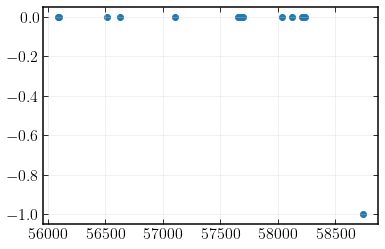

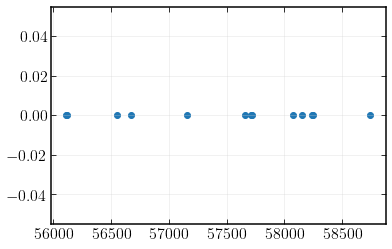

In [96]:
plt.scatter(comp_dict['old_gam_start'], comp_dict['old_gam_start'] - comp_dict['new_gam_start'])
plt.show()

plt.scatter(comp_dict['old_gam_stop'], comp_dict['old_gam_stop'] - comp_dict['new_gam_stop'])
plt.show()

In [98]:
comp_dict

{'Name': array(['V1707 Sco', 'V392 Per', 'V906 Car', 'V357 Mus', 'V549 Vel',
        'V5856 Sgr', 'V5855 Sgr', 'V407 Lup', 'V5668 Sgr', 'V1369 Cen',
        'V339 Del', 'V959 Mon', 'V1324 Sco'], dtype='<U9'),
 'old_gam_start': array([58740., 58238., 58216., 58129., 58037., 57700., 57686., 57657.,
        57105., 56634., 56520., 56097., 56093.]),
 'old_gam_stop': array([58744., 58246., 58239., 58156., 58070., 57715., 57712., 57660.,
        57158., 56672., 56547., 56119., 56110.]),
 'new_gam_start': array([58741., 58238., 58216., 58129., 58037., 57700., 57686., 57657.,
        57105., 56634., 56520., 56097., 56093.]),
 'new_gam_stop': array([58744., 58246., 58239., 58156., 58070., 57715., 57712., 57660.,
        57158., 56672., 56547., 56119., 56110.])}

In [97]:
print(old_gammas[['Name', 'gamma_stop']])

         Name   gamma_stop
1   V5855 Sgr      57712.0
4   V5668 Sgr      57158.0
6    V357 Mus      58156.0
15   V745 Sco      56695.0
16   V906 Car      58239.0
26   V549 Vel      58070.0
27   V339 Del      56547.0
31   V407 Lup      57660.0
34  V1535 Sco  57070.99997
41  V3890 Sgr      58739.0
46  V1707 Sco      58744.0
47  V1324 Sco      56110.0
52  V1369 Cen      56672.0
55   V392 Per      58246.0
61   V959 Mon      56119.0
68  V5856 Sgr      57715.0


In [83]:
print(elias_novae[['Nova', 'gamma_end']])

         Nova  gamma_end
0      YZ Ret    57958.0
1   V1707 Sco    58744.0
2    V392 Per    58246.0
3    V906 Car    58239.0
4    V357 Mus    58156.0
5    V549 Vel    58070.0
6   V5856 Sgr    57715.0
7   V5855 Sgr    57712.0
8    V407 Lup    57690.0
9   V5668 Sgr    57158.0
10  V1369 Cen    56672.0
11   V339 Del    56547.0
12   V959 Mon    56119.0
13  V1324 Sco    56110.0


ValueError: setting an array element with a sequence.

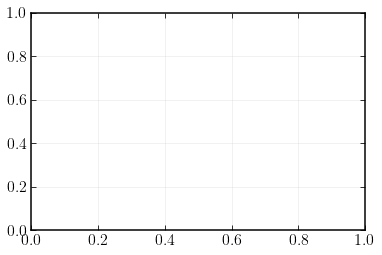

In [74]:
plt.scatter(old_gammas['gamma_start'], old_gammas['gamma_stop'])
plt.scatter(elias_novae['gamma_start'], elias_novae['gamma_end'])

In [49]:
df = pd.read_pickle('../master_nova_dataframe.pkl')

In [50]:
def clean_mag_col(p):
    if type(p) == str:
        if '(I)' in p:
            p = p.split(' (I)')[0]
        p = float(p)
    else:
        p = float(p)
    return p

In [51]:
df['Peak'] = df['Peak'].apply(clean_mag_col)

In [53]:
df['gamma_lim']    

0     0.7
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
64    0.8
65    NaN
66    NaN
67    0.8
68    2.2
Name: gamma_lim, Length: 69, dtype: float64

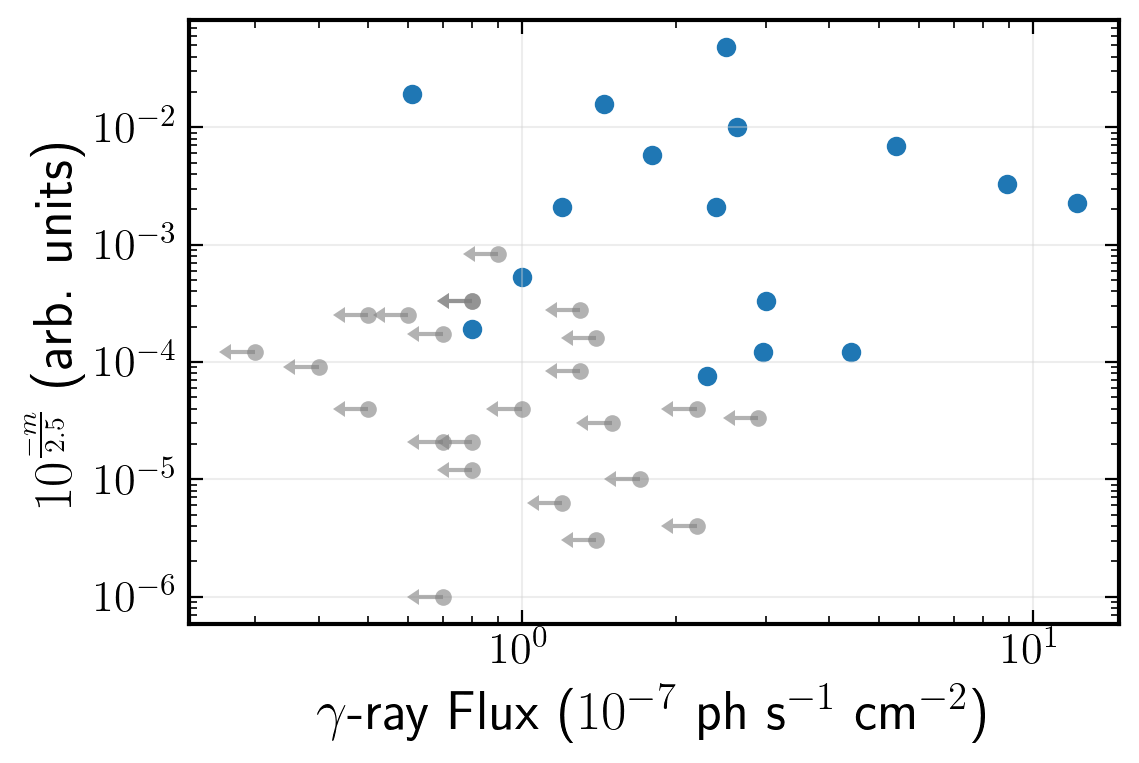

In [62]:
fig, ax = plt.subplots(dpi=200)

arb_fl = 10.**(-df["Peak"] / 2.5)
plt.scatter(df['gamma_norm'][df['gamma']], arb_fl[df['gamma']])

where_lims = ~np.isnan(df['gamma_lim'])
xerrs = [0.1*gam_lim for gam_lim in df['gamma_lim'][where_lims]]
plt.errorbar(df['gamma_lim'][where_lims], arb_fl[where_lims], xuplims=True,
            xerr=xerrs, ls='', color = 'grey', marker='o', alpha=0.6, markeredgewidth=0.0)

plt.xlabel(r'$\gamma$-ray Flux ($10^{-7}$ ph s$^{-1}$ cm$^{-2}$)', fontsize=20)
plt.ylabel(r'$10^{\frac{-m}{2.5}}$ (arb. units)', fontsize=20)

plt.loglog()
plt.show()

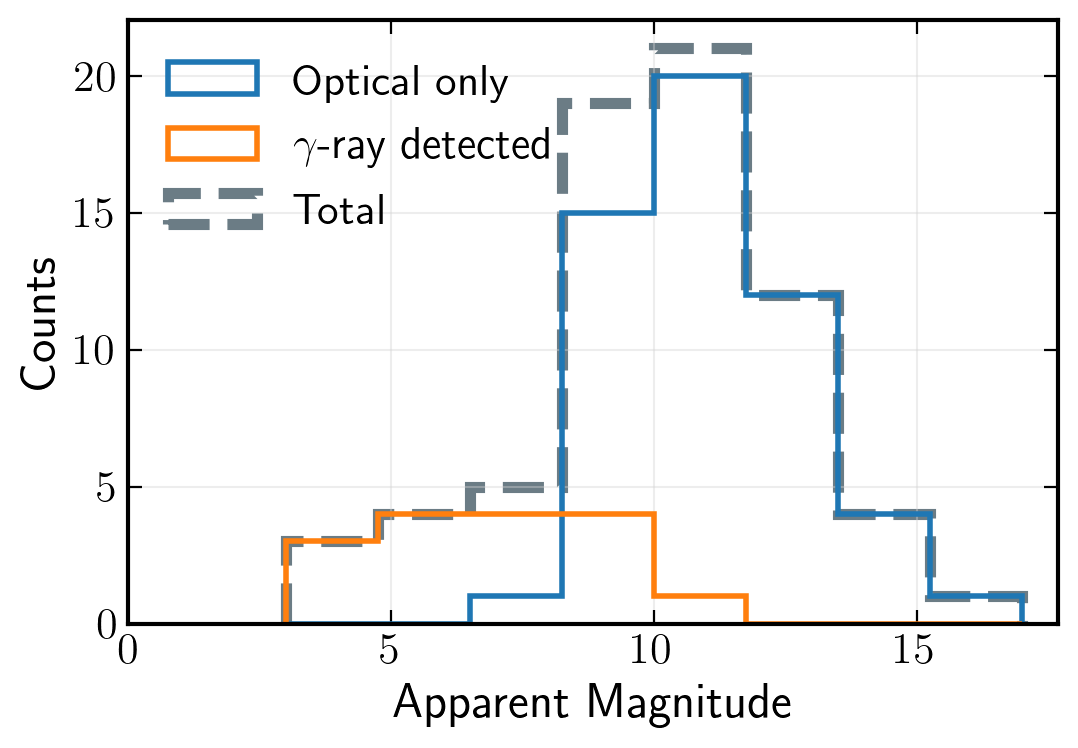

In [84]:
fig, ax = plt.subplots(dpi=200)

mag_bins = np.linspace(3., 17., 9)

plt.hist(df['Peak'][~df['gamma']],
         bins=mag_bins, histtype='step', lw=2., label='Optical only'
        )

plt.hist(df['Peak'][df['gamma']],
         bins=mag_bins, histtype='step', lw=2., label=r'$\gamma$-ray detected'
        )
                    
plt.hist(df['Peak'], lw=4., ls='--', color=sns.xkcd_rgb['battleship grey'],
        histtype='step', label='Total', bins=mag_bins, zorder=1)

plt.legend(loc=2, frameon=False)
plt.xlabel('Apparent Magnitude')
plt.ylabel('Counts')
plt.xlim(0, plt.xlim()[1])

plt.show()

,index,Name,Date,Peak,RA,Dec,gamma,gamma_start,gamma_stop,gamma_norm,gamma_ind,gamma_cutoff,refs
0,1,V959 Mon,2016-06-19 00:00:00.000,5.0,99.911420,5.897780,True,56097.0,56119.0,2.64,1.50,1.3,xray:1EliasAnna
3,4,V1535 Sco,2015-02-11 00:00:00.000,8.2,255.859044,-35.071616,True,57063.99997,57070.99997,1.00,2.30,inf,AnnaAnna
11,20,V5856 Sgr,2016-11-09 00:00:00.000,5.4,275.217710,-28.370030,True,57700.0,57715.0,5.40,1.86,5.9,xray:5Elias
12,23,V745 Sco,2014-02-06 00:00:00.000,8.7,268.842614,-33.249600,True,56694.0,56695.0,3.00,2.20,inf,AnnaAnna
15,31,V407 Lup,2019-09-25 09:36:00.000,5.6,232.257580,-44.828000,True,57657.0,57660.0,1.80,2.20,inf,"xray:3, This workElias"
16,33,V906 Car,2018-03-16 21:07:12.000,6.62,159.064276,-59.598258,True,58216.0,58239.0,12.20,1.76,5.9,xray:9Elias
19,40,V1369 Cen,2013-12-06 07:12:00.000,3.3,208.689012,-59.151158,True,56634.0,56672.0,2.51,2.00,2.0,xray:2EliasAnna
20,43,V5668 Sgr,2015-03-21 00:00:00.000,4.3,279.237500,-28.928330,True,57105.0,57158.0,0.61,2.11,inf,xray:2EliasAnna
27,53,V392 Per,2018-04-29 12:00:00.000,6.2,70.839040,47.357186,True,58238.0,58246.0,8.90,1.90,inf,"xray:10,11Elias"
31,60,V5855 Sgr,2016-10-24 19:12:00.000,9.8,272.617880,-27.499700,True,57686.0,57712.0,2.96,2.26,inf,xray:4Elias


In [24]:
df["Peak"]

0       5.0
1       8.7
2      11.2
3       8.2
4     11.03
      ...  
64     14.1
65     10.3
66     11.0
67     11.7
68     11.0
Name: Peak, Length: 69, dtype: object